In [1]:
%cd ../../../../

/home/k.rooijers/Projects/OOPS_2023


/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


---

In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn

In [4]:
from matplotlib import pyplot as plt

In [5]:
import xarray

In [6]:
np.random.seed(42)

In [7]:
def sluggify(s):
    from string import ascii_letters, digits
    return "".join(c for c in s if c in ascii_letters or c in digits or c in "-_."
    ).replace(":", "_").replace("-", "_").replace(".", "_")

---

### Data loading

In [8]:
sample_subset = pd.read_csv("pipeline_activation/samplesheet.tsv", sep="\t")

In [9]:
intensities = pd.read_csv(
    "pipeline_activation/intensity-values.tsv",
    sep="\t", index_col=0,
)

In [10]:
w_valid = intensities['w_valid']

In [11]:
hgnc_metadata = pd.read_csv(
    "pipeline_activation/raw/hgnc_metadata.tsv.gz",
    sep="\t", index_col=0,
)

---

In [12]:
Y = intensities[[col for col in sample_subset['sample_label']]].values

In [13]:
with np.errstate(invalid='ignore', divide='ignore'):
    Yl = np.log10(np.ma.masked_less_equal(Y, 0))

In [14]:
log_intensity_medians = pd.read_csv("pipeline_activation/model-output/log_intensity_medians.tsv", index_col=0, sep="\t").values.squeeze()

In [15]:
Yln = Yl - (log_intensity_medians / np.log(10))

Load MAP:

In [16]:
map_ds = xarray.load_dataset("pipeline_activation/model-output/global_map.h5")

In [17]:
E = xarray.concat([
    map_ds['E'], map_ds['Ederiv'].rename({"deriv_coef": "coef"})
], dim="coef")

---

Clustering on coeffs:

In [18]:
from sklearn.preprocessing import scale

import hdbscan

In [19]:
from scipy.cluster.hierarchy import dendrogram, average, centroid
from scipy.spatial.distance import pdist

In [20]:
from matplotlib.transforms import blended_transform_factory

In [21]:
dict(enumerate(E.coords['coef'].values))

{0: 'Intercept',
 1: 'libtype[S.OOPS]',
 2: 'act[S.no]',
 3: 'cl[S.no]',
 4: 'libtype[S.OOPS]:act[S.no]',
 5: 'libtype[S.OOPS]:cl[S.no]',
 6: 'act[S.no]:cl[S.no]',
 7: 'libtype[S.OOPS]:act[S.no]:cl[S.no]',
 8: 'OOPS_abundance',
 9: 'activation',
 10: 'activation_FP',
 11: 'RBPness',
 12: 'lt_deltaRBPness',
 13: 'act_deltaRBPness',
 14: 'act_deltaCL'}

In [22]:
cluster_coeffs = [
    'Intercept',
    'activation',
    'RBPness',
    'act_deltaRBPness',
]

In [23]:
X = E.sel(coef=cluster_coeffs)

X.shape

(5561, 4)

In [24]:
np.abs(X).sum(axis=0).to_pandas()

coef
Intercept           1485.974115
activation           101.130638
RBPness               88.792521
act_deltaRBPness      65.999543
dtype: float64

In [25]:
labels = hdbscan.HDBSCAN(
    min_samples=12,
    min_cluster_size=20,
# ).fit_predict(X)
).fit_predict(scale(X) * np.array([0.05, 1., 2., 1.]))

In [26]:
from collections import Counter

In [27]:
len(set(labels))

9

In [28]:
l2i = {k: i for (i, k) in enumerate(sample_subset['sample_label'].values)}

In [29]:
grouping = (
    sample_subset
    .groupby(['batch', 'library_type'])
    .apply(
        lambda df: list(df['sample_label'].map(l2i.get)),
        include_groups=False,
    ).to_dict()
)

grouping

{('batch_2022_DDA', 'OOPS'): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 ('batch_2022_DDA', 'fullproteome'): [12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23]}

In [30]:
with np.errstate(invalid="ignore", divide='ignore'):
    Yln_z_indep = np.ma.masked_invalid(np.concatenate([
        scale(Yln[:, idxs].filled(np.nan), axis=1)
        for idxs in [grouping[k] for k in grouping.keys()]
    ], axis=1))

/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:246: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:254: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/k.rooijers/.ca

In [31]:
assert np.isclose(Yln_z_indep.mean(axis=1).compressed(), 0).all()

In [32]:
# set up sample grouping / break indicators
v_it = list(sample_subset.set_index('sample_label')[['library_type', 'crosslinked', 'activated']].itertuples(index=False))

v_breaks = np.r_[
    True,
    np.array([a != b for a, b in zip(v_it[1:], v_it[:-1])]),
    True,
]

Text(0.5, 1.0, 'Cluster Z-score averages\n(nr of genes in parentheses)')

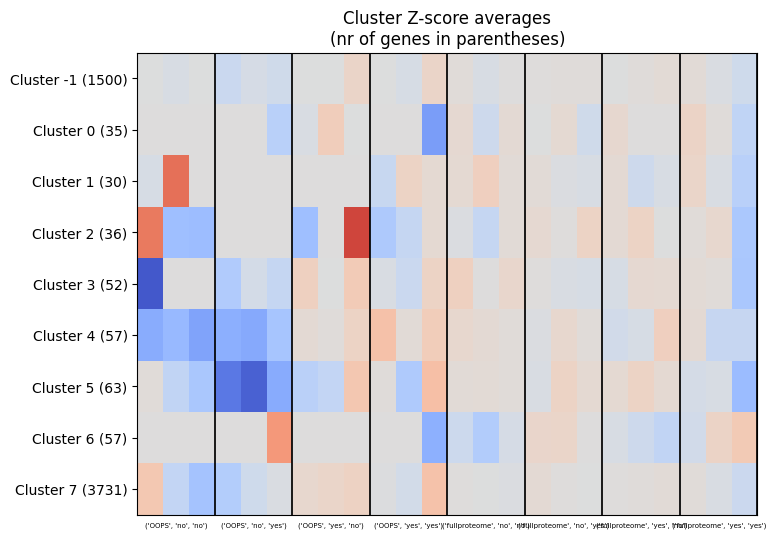

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.pcolormesh(
    np.array([
        Yln_z_indep[w_valid][ilabels, :].mean(axis=0)
        for ilabels in (
            labels == ilabel
            for ilabel in sorted(set(labels))
        )
    ]),
    vmin=-2, vmax=2,
    cmap="coolwarm",
)

ax.invert_yaxis();
ax.set_yticks(np.arange(len(set(labels))) + 0.5);
ax.set_yticklabels(
    [
        "Cluster %s (%d)" % (str(x), (labels == x).sum())
         for x in sorted(set(labels))
    ]
);

ax.set_xticks([]);
for xpos in np.where(v_breaks)[0]:
    ax.axvline(xpos, color="black", lw=1.25, zorder=100)
for xpos_left, xpos_right in zip(np.where(v_breaks)[0][:-1], np.where(v_breaks)[0][1:]):
    ax.text(
        (xpos_left + xpos_right) / 2, 0. - 0.015,
        s=tuple(v_it[xpos_left]), ha="center", va="top",
        size=5,
        transform=blended_transform_factory(ax.transData, ax.transAxes),
    )

ax.set_title("Cluster Z-score averages\n(nr of genes in parentheses)")

Global figure, all genes:

In [34]:
Yln_z_clusteravg = np.ma.masked_invalid(np.array([
    Yln_z_indep[w_valid][labels == icluster, :].mean(axis=0).filled(np.nan)
    for icluster in sorted(set(labels))
]))

Yln_z_clusteravg = Yln_z_clusteravg.filled(0.)

cluster_order = np.array(dendrogram(average(pdist(Yln_z_clusteravg)), no_plot=True)['leaves'])

In [35]:
within_clustering_order = {}  # cluster-id -> idxs of genes (subset on cluster)

for cluster_id in sorted(set(labels)):
    mat = Yln_z_indep[w_valid][labels == cluster_id, :].filled(0.)
    mat_order = np.array(dendrogram(centroid(pdist(mat)), no_plot=True)['leaves'])
    within_clustering_order[cluster_id] = mat_order

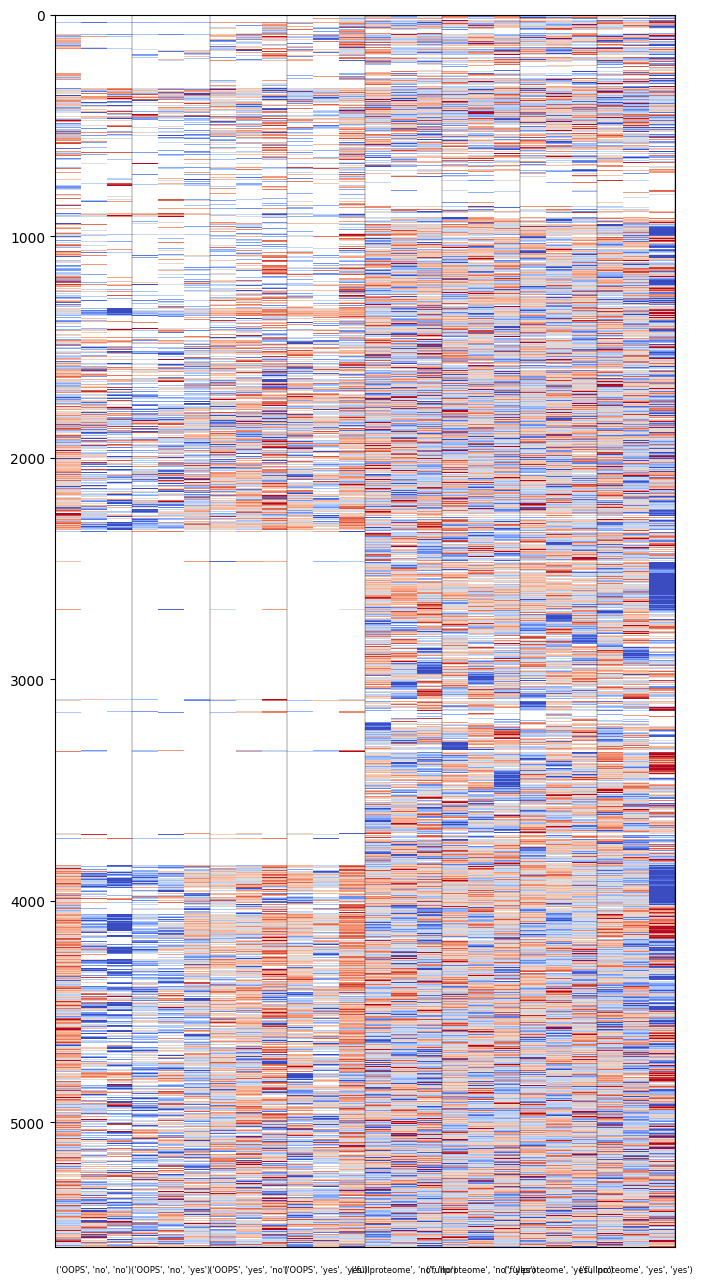

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))

ax.pcolormesh(
    np.concatenate([
        Yln_z_indep[w_valid][labels == cluster_id, :][within_clustering_order[cluster_id]]
        for cluster_id in np.array(sorted(set(labels)))[cluster_order]
    ], axis=0),
    vmin=-2, vmax=2., cmap="coolwarm",
)

ax.set_xticks([]);
for xpos in np.where(v_breaks)[0]:
    ax.axvline(xpos, color="black", lw=0.25, zorder=100)
for xpos_left, xpos_right in zip(np.where(v_breaks)[0][:-1], np.where(v_breaks)[0][1:]):
    ax.text(
        (xpos_left + xpos_right) / 2, 0. - 0.015, 
        s=tuple(v_it[xpos_left]), ha="center", va="top", 
        size=6,
        transform=blended_transform_factory(ax.transData, ax.transAxes),
    )
    
ax.invert_yaxis();

fig.savefig("pipeline_activation/figures/zscaled-heatmap.pdf", format="pdf")

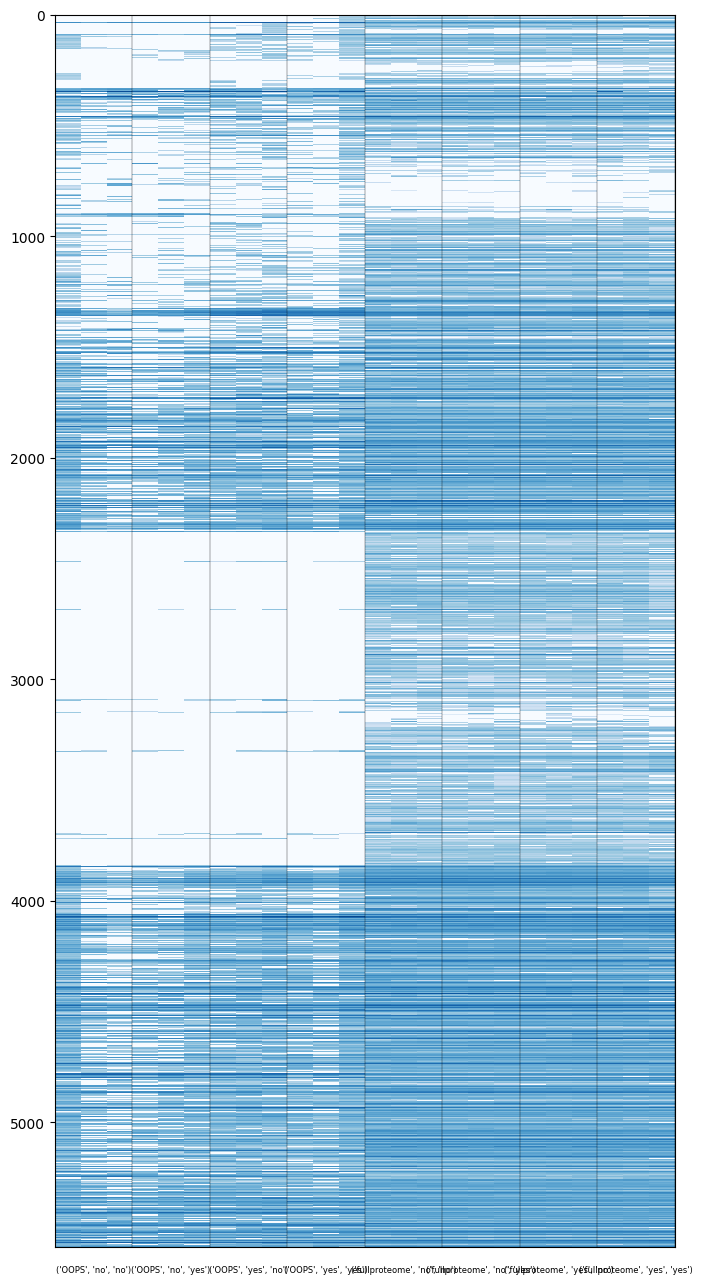

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))

ax.pcolormesh(
    np.concatenate([
        Yln[w_valid][labels == cluster_id, :][within_clustering_order[cluster_id]].filled(-3)
        for cluster_id in np.array(sorted(set(labels)))[cluster_order]
    ], axis=0),
    cmap="Blues",
)

ax.set_xticks([]);
for xpos in np.where(v_breaks)[0]:
    ax.axvline(xpos, color="black", lw=0.25, zorder=100)
for xpos_left, xpos_right in zip(np.where(v_breaks)[0][:-1], np.where(v_breaks)[0][1:]):
    ax.text(
        (xpos_left + xpos_right) / 2, 0. - 0.015, 
        s=tuple(v_it[xpos_left]), ha="center", va="top", 
        size=6,
        transform=blended_transform_factory(ax.transData, ax.transAxes),
    )
    
ax.invert_yaxis();

fig.savefig("pipeline_activation/figures/log-intensity-heatmap.pdf", format="pdf")

---